# Imports

In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from fa2 import ForceAtlas2
import numpy as np
import csv
import networkx as nx
import os
!pip install python-louvain
import community as community
#couchsurfing API is external API locally saved also available in our github: https://github.com/eikekutz/SocialGraphFinalProject
from couchsurfing import Api
from random import randint
from time import sleep
from geopy import geocoders
import unidecode
import conda
import pickle
import collections

#Necessary Settings for the conda package to work with the Basemap if it gives errors
# - if you are missing Basemap package, just please execute: conda install -c conda-forge basemap

# - if it still doesn't work try to uncomment lines below:

#conda_file_dir = conda.__file__
#conda_dir = conda_file_dir.split('lib')[0]
#proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
#os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap


  Running setup.py bdist_wheel for python-louvain: started
  Running setup.py bdist_wheel for python-louvain: finished with status 'done'
  Stored in directory: C:\Users\Kamil\AppData\Local\pip\Cache\wheels\c3\b0\db\198c7453d5169907dbdbb090eebc0c6839f75e36b09c6dc7aa
Successfully built python-louvain


You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


 * **0\. Data Extraction**
    * 0.1\. Couchsurfing API Data Gathering
        * 0.1.1\. Get Hosts Data
        * 0.1.2\. Get Reviews and Reviewers Data
    * 0.2\. Data Merging
    * 0.3\. Adding Geo Location of Users
    * 0.4\. Cleaning Data
    
* 1\. Project's objective (**fix list problem**)
    * 1.1\. What do we want to answer in this project
    * 1.2\. Datasets limitations
    
* **2\. Preliminary Data Analysis**
    * 2.1\. User
        * 2.1.1\. User Analysis
        * 2.1.2\. User Statistics
        * 2.1.3\. User Graphs
    * 2.2\. City
        * 2.2.1\. City Clustering
        * 2.2.2\. City Analysis
        * 2.2.3\. City Statistics
        * 2.2.4\. City Graphs

* **3\. Network Construction**
    * 3.1\.User 
        * 3.1.1\. Initial Analysis
    * 3.2\.City 
        * 3.2.1\. Initial Analysis

* **4\. Basic Network Analysis**
    * 4.1\. Degree Distribution
        * 4.1.1 Network degree (in, out, total) distribution
        * 4.1.2 Nodes' degree (in and out) comparison
    * 4.2\. Power-laws and Friendship Paradox
    * 4.3\. Centrality
        * 4.3.1 Betweenness Centrality
        * 4.3.2 Eigenvector Centrality
    * 4.4\. Assortativity
    * 4.5\. Modularity and Communities
    * 4.6\. Network Statistics
* **5\. Analysis of Review data**
    * 5.1\. Wordclouds
    * 5.2\. Happiness Averages
        * 5.2.1\. Users
        * 5.2.2\. Cities

* **6\. Analysis of specific Users**
    * 6.1\. Get Profile Data
    * 6.2\. Combined sentiment
        * 6.1.1\. Overall/Host/Surfer -Review
        * 6.1.1\. Image Sentiment
        * 6.1.1\. Profile description Sentiment ( 
    * 6.2\. Best/Worst User
        * 6.2.1\. Best/Worst Couchsurfer
        * 6.2.1\. Best Host

* **7\. Discussion**

# 0.Data Extraction#

In [2]:
def getHostFromCity(city,latitude,longitude):
    '''
    getting all the host data within a circle with a radius of 25km 
    max 20 pages with each 100 users
    '''
    print("Getting results for ",city,latitude,longitude)
    for p in range(1,20):
        print(p)
        ##hosts = api.get_hosts(city,25,100,p)
        ##hosts = api.get_hosts(city,25,100,None,'best_match',"yes,maybe",None,p,last_login)
        hosts = api.get_hosts_latlong(latitude,longitude,p,100,25,4)
        writeCityResults2File(hosts,city,p)
        sleep(randint(2,5))

In [3]:
def writeCityResults2File(results,cityString,page):
    '''
    writing hosts to csv file 100 users for each file
    '''
    with open('data/Top50/hosts/'+cityString+str(page)+'.csv','w',newline="") as f:
        writer = csv.writer(f,delimiter = ',')
        # Write CSV Header, If you dont need that, remove this line
        writer.writerow(["id",
                "publicName",
                "avatarUrl",
                "isVerified",
                "status",
                "lastLogin",
                "aboutText",
                "responseRate",
                "responseTimeText",
                'responseRateText',
                "totalReferencesCount",
                "profileLink",
                "friendsCount",
                "languages",
                "city"])

        for host in results['results']:
            writer.writerow([host["id"],
                    host["publicName"],
                    host["avatarUrl"],
                    host["isVerified"],
                    host["status"],
                    host["lastLogin"],
                    host["aboutText"],
                    host["responseRate"],
                    host["responseTimeText"],
                    host["responseRateText"],
                    host["totalReferencesCount"],
                    host["profileLink"],
                    host["friendsCount"],
                    host["languages"],
                    cityString])

In [98]:
#import nodes to get id from nodes/hosts
def importHosts(index):
    '''
    Import merged hosts to get id, which is used to download the reviews for each user
    '''
    hosts = pd.DataFrame() #creates a new dataframe that's empty
    city = cities.loc[index]
    for p in range(1,15):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv')
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
    return hosts

In [3]:
def createRevCityList(city): 
    '''
    Create a csv file for the given city to store reviews of the city
    '''
    with open('data/Top50/reviews/'+city+'Rev.csv','w',newline="") as f:
            writer = csv.writer(f,delimiter = ',')
            writer.writerow(["id",
                    "text",
                    "createdDate",
                    "experience",
                    "relationshipType",
                    "isPostTrip",
                    "to",
                    "from",
                    "fromPublicName",
                    "fromPublicAddressId",
                    "fromPublicAddressDescription",
                    "fromAvatarUrl",
                    "fromStatus",
                    "fromIsVerified",
                    "fromIsDeleted",
                    "fromBlockedBy",
                    "inverseReference",
                    "response"])

In [4]:
def appendReview(file,city):
    '''
    Append Reviews of the user on the specific city reviews csv file
    '''
    with open('data/Top50/reviews/'+city+'Rev.csv','a',newline="") as f:
        writer = csv.writer(f,delimiter = ',')
        for host in file['results']:
            writer.writerow([host["id"],
                host["text"],
                host["createdDate"],
                host["experience"],
                host["relationshipType"],
                host["isPostTrip"],
                host["to"]['id'],
                host["from"]['id'],
                host["from"]["publicName"],
                host["from"]["publicAddress"]["id"],
                host["from"]["publicAddress"]["description"],
                host["from"]["avatarUrl"],
                host["from"]["status"],
                host["from"]["isVerified"],
                host["from"]["isDeleted"],
                host["from"]["blockedBy"],
                host["inverseReference"],
                host["response"]])

In [5]:
def getReferenceForCity(index):
    '''
    Get the reviews for every hosts for a given city based on the downloaded host dataset
    '''
    hosts= importHosts(index=index)
    city = cities.loc[index]
    print("Getting results for ",city['name'])
    createRevCityList(city['name'])
    for idx,host in hosts.iterrows():
        test=api.get_references(uid=host['id'],type='host')
        appendReview(test,city['name'])
        test=api.get_references(uid=host['id'],type='surf')
        appendReview(test,city['name'])     

## 0.1. Couchsurfing API Data Gathering

In [ ]:
#Get all the hosts from a city , iterating over the city list
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    getHostFromCity(city['name'],city['lat'],city['lng'])
    sleep(randint(10,20))

In [ ]:
#Getting the references for all the hosts
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    if idx>10:
        getReferenceForCity(idx)
        sleep(randint(5,10))

## 0.2. Data Merging



In [221]:
#Merging host's data
cities = pd.read_csv('data/Top50/top50cities.csv',delimiter=',')
hosts = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    for p in range(1,14):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv',index_col=False,dtype={'id': np.int64})
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
hosts=hosts.drop_duplicates()

In [224]:
#merging review data
rev = pd.DataFrame() #creates a new dataframe that's empty
rev= pd.read_csv('data/reviews_total_geo_3.csv',dtype={'id':np.int64,'to':np.int64,'from':np.int64})
rev=rev.drop_duplicates()

In [225]:
#adding sentiment analysis of the reviews
# load data from pickle
sentiment_per_review_dict = pickle.load( open( 'data/Top50/reviews/Pickles/SentimentPerReview_Dict.pickle', "rb" ) )
# map values from dictionary into dataframe by rev_id
rev['sentimentValue'] = rev['id'].map(sentiment_per_review_dict)

print(list(sentiment_per_review_dict.values()).count(None),' of ',len(list(sentiment_per_review_dict)), 'has been ommited due to the lack of sentiment')
                                    

9021  of  96085 has been ommited due to the lack of sentiment


In [282]:
# create multigraph 
G_withSentValue = nx.MultiDiGraph()

# filter out reviews from these that don't have sentiment value
couchserfing_reviews = rev.loc[ rev['sentimentValue'].notnull()]
#G_withSentValue.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])
#append edges to the multigraph
couchserfing_reviews=couchserfing_reviews.rename(columns = {'sentimentValue':'weight'})
G_withSentValue = nx.from_pandas_edgelist(couchserfing_reviews, 'from', 'to', edge_attr=['weight','relationshipType'], create_using=nx.MultiDiGraph())
couchserfing_reviews=couchserfing_reviews.rename(columns = {'weight':'sentimentValue'})

# todo: filter nodes without connection abour 10000
nx.set_node_attributes(G_withSentValue, pd.Series( pd.Series( hosts.city.values, index=hosts.id).to_dict()).to_dict(), 'city')
#nx.set_node_attributes(G_withSentValue, pd.Series(nodes.gender, index=nodes.node).to_dict(), 'gender')

print(len(G_withSentValue.nodes))
print(len(couchserfing_reviews))
print(len(G_withSentValue.nodes))
print(len(G_withSentValue.edges))
#test
#print(len(G_withSentValue.edges))
#(len(couchserfing_reviews))

80724
86365
80724
86365


In [300]:
node_to_city_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[0] not in node_to_city_dict:
            node_to_city_dict[node[0]] = node[1]['city']
    else:
        node_to_city_dict[node[0]] = 'outside'

In [301]:
nx.set_node_attributes(G_withSentValue, node_to_city_dict, 'city')

In [304]:
G_withSentValue.nodes[2002893465]

{'city': 'Berlin'}

In [289]:
couchserfing_reviews.loc[couchserfing_reviews['to'] == 2002893465]

id                                               text  \
22056  27257300  Olaf a.k.a. Bitchlette Extraordinaire is posit...   
22057  26923118  Olaf is a very fun dude with a lot of  crazy s...   
22058  26815373  Olaf and his friend are fantastic people! Very...   
22059  26799978  Olaf and his friend were super fun guest. They...   
22060  26774853  Hosting Olaf and his boy (friend) from childho...   
22061  26740983  Awesome dude!!!\r\nLoved chill every second wi...   
22062  26661589  First,  he is not paying me for what I’m about...   
22063  26651433  Olaf is very friendly, energetic and opened gu...   
22064  26628908  Olaf is awesome person, smart and easy. \r\nWe...   
22065  27242374  Olaf is really cool and open. He loves jokes, ...   
22066  27178464  Olaf is a very friendly person, interesting to...   
22067  27158321  Mate it’s hard to explain mate, we hung out a ...   
22068  27137054  Olaf is a very funny and open guy! It was grea...   
22069  27123184  Our first CS experience, and man was it great!...   
22070  27094770  Olaf is a really cool guy he was in a hurry an...   
22071  27092506  We only stayed at Olaf's place for one night, ...   
22072  27082028  I stayed with Olaf for a night. He is a friend...   
22073  27050908  My first couch surfing experience and I'm real...   
22074  27038008  Olaf made sure that I was comfortable and havi...   
22075  27032937  I had the pleasure to meet Olaf and he's reall...   
22076  27021780  My first overnight on couchsurfing. It was rea...   
22077  26986348  Me and my friend Fatima have been hosted by Ol...   
22078  26623401  Olaf is really cool 😎 We spent a good time tog...   
22080  26447848  Olaf is super cool adviser :) \r\nThanks to hi...   
22081  26333772  Wonderful host who showed me how cooking  an a...   
22082  26260789  This guy helped me in last hours, super open m...   

                createdDate experience relationshipType  isPostTrip  \
22056  2018-11-12T15:28:08Z   positive             host        True   
22057  2018-09-27T16:41:06Z   positive             host        True   
22058  2018-09-14T16:16:36Z   positive             host        True   
22059  2018-09-12T19:06:17Z   positive             host        True   
22060  2018-09-09T23:29:03Z   positive             host        True   
22061  2018-09-05T23:44:46Z   positive             host        True   
22062  2018-08-28T09:22:59Z   positive             host        True   
22063  2018-08-27T09:15:20Z   positive             host        True   
22064  2018-08-24T21:43:39Z   positive             host        True   
22065  2018-11-10T14:43:18Z   positive             surf        True   
22066  2018-11-01T12:33:28Z   positive             surf        True   
22067  2018-10-29T14:13:12Z   positive             surf        True   
22068  2018-10-26T13:47:09Z   positive             surf        True   
22069  2018-10-24T12:21:53Z   positive             surf        True   
22070  2018-10-20T15:35:15Z   positive             surf        True   
22071  2018-10-20T09:56:40Z   positive             surf        True   
22072  2018-10-18T16:18:59Z   positive             surf        True   
22073  2018-10-14T14:19:31Z   positive             surf        True   
22074  2018-10-12T16:22:51Z   positive             surf        True   
22075  2018-10-11T20:41:49Z   positive             surf        True   
22076  2018-10-10T10:29:09Z   positive             surf        True   
22077  2018-10-05T16:32:16Z   positive             surf        True   
22078  2018-08-24T11:17:12Z   positive             surf        True   
22080  2018-08-07T08:33:21Z   positive             surf        True   
22081  2018-07-26T20:46:31Z   positive             surf        True   
22082  2018-07-19T12:52:51Z   positive             surf        True   

               to        from       fromPublicName  fromPublicAddressId  \
22056  2002893465  2006159082       Yoana Vancheva          204003269.0   
22057  2002893465  2009090784          Oskar Nowik    

In [291]:
#creatdiGraph to see how many edges will be overriten calculation of re-visites
G = nx.DiGraph()
G = nx.from_pandas_dataframe(couchserfing_reviews, 'from', 'to')


In [292]:
print(G_withSentValue[2001999679][2009059021])
print(G_withSentValue[2007724821][2009059021])
#print(G_withSentValue[2002893465][1006973581])

#print(G_withSentValue[1006973581][2002893465])

rev.head(2)

{0: {'weight': 6.768571428571428, 'relationshipType': 'host'}}
{0: {'weight': 6.403125000000003, 'relationshipType': 'surf'}}


id                                               text  \
0  27077307  Amazing chef and humble human being. Willing t...   
1  27152728  Amazing boy with amazing family . He met me up...   

            createdDate experience relationshipType  isPostTrip          to  \
0  2018-10-17T22:09:22Z   positive             host        True  2009059021   
1  2018-10-28T19:16:31Z   positive             surf        True  2009059021   

         from     fromPublicName  fromPublicAddressId       ...        \
0  2001999679      Dhanush Anand          109610804.0       ...         
1  2007724821  Bakhar Sardzhaeva          271153483.0       ...         

  fromIsDeleted fromBlockedBy inverseReference  response        lat  \
0         False           NaN              NaN       NaN   3.695000   
1         False           NaN              NaN       NaN  25.258172   

         lng       city country  vienna  sentimentValue  
0  96.868000  setiabudi      id     NaN         6.76857  
1  55.304717      dubai      ae     NaN         6.40313  

[2 rows x 24 columns]

## 0.3. Adding Geo Location of Users



In [ ]:
cities_not_found = []
def getCityCoords(name):
    gn = geocoders.GeoNames(username='kacper')
    try:
        loc = gn.geocode(name, timeout=10)
        if loc is None:
            try: 
                loc =gn.geocode(name.split(',')[0],timeout=10)
                if loc is None:
                    raise TypeError
            except Exception as inst:
                print('This city was not found:',name)
                return None
    except Exception as inst:
        print('This city was not found:',name)
        cities_not_found.append(name)
        return None
    #print(len(loc))
   # print(loc[0].raw)
    return loc

In [ ]:
#source: https://www.maxmind.com/en/free-world-cities-database
worldCities = pd.read_csv('../worldcitiespop.txt',encoding = "ISO-8859-1")
#source: https://datahub.io/core/country-list#resource-data
cc= pd.read_csv('data/country_map.txt')

In [15]:
#Example how the data look like:
print('Number of entries worldCitiespop.txt: ',len(worldCities))
worldCities.head(3)

Number of entries worldCitiespop.txt:  3173958


Country        City  AccentCity Region  Population   Latitude  Longitude
0      ad       aixas       Aixàs      6         NaN  42.483333   1.466667
1      ad  aixirivali  Aixirivali      6         NaN  42.466667   1.500000
2      ad  aixirivall  Aixirivall      6         NaN  42.466667   1.500000

In [ ]:

uniqueCities=rev.fromPublicAddressDescription.unique()
uniqueCities = uniqueCities.tolist()

In this Part we map a geographical position to every review.
With this information we know the reviewer geographical position.
Due to the high number of reviewer's unique locations and the geopy API's limitation of 5000 requests a day we used the worldcitiespop.txt.
If an entry couldn't be found in this list we used the geopy API to supplement the missing entries.
If a review's location couldn't be found it will be droppend afterwards.
The nummber of not found location is 815 out of 96085 with is a 0.848% of the reviews data.

In [4]:
exList=["nan"]
for city in unique:
    if all([c[1]=='NaN'for c in rev.loc[rev.fromPublicAddressDescription==city]['lat'].iteritems()]):
        if str(city).lower() not in exList:
            #Search for entry in the worldcities list and map with country code (cc) if necessary
            loc = worldCities.loc[worldCities.City==city.split(',')[0].lower().strip()]
            if len(loc.index)>1:
                try:
                    countryCode = cc.loc[cc.Name==city.split(',')[-1].strip().lower().title()]['Code'].values[0]
                    loc =loc.loc[loc.Country==countryCode.lower()].head(1)
                except:
                    loc=loc.head(1)
            if len(loc.head(1).index)==0:
                c=test=unidecode.unidecode(city)
                loc = worldCities.loc[worldCities.City==c.split(',')[0].lower().strip()].head(1)
                if len(loc.index)>1:
                    try:
                        countryCode = cc.loc[cc.Name==c.split(',')[-1].strip().lower().title()]['Code'].values[0]
                        loc =loc.loc[loc.Country==countryCode.lower()].head(1)
                    except:
                        loc=loc.head(1)  

            if len(loc.head(1).index)==1:
                l=rev.loc[rev.fromPublicAddressDescription==city].index.tolist()
                for i in l:
                    rev.set_value(i,'lat',loc.Latitude.values[0])
                    rev.set_value(i,'lng',loc.Longitude.values[0])
                    rev.set_value(i,'city',loc.City.values[0])
                    rev.set_value(i,'country',loc.Country.values[0])

            else:
            #is the entry not found in the worldcities use the API to download the geoposition    
                print('try api for :',city)
                res = getCityCoords(city)
                try:
                    l=rev.loc[rev.fromPublicAddressDescription==city].index.tolist()
                    for i in l:
                        rev.set_value(i,'lat',res.latitude)
                        rev.set_value(i,'lng',res.longitude)
                        rev.set_value(i,'city',res.address.split(' ')[0].lower())
                        rev.set_value(i,'country',res.address.split(' ')[-1].lower())
                except:
                    print('Could not found ',city)
export_csv = rev.to_csv ('data/reviews_total_geo_x.csv', index = None, header=True)

NameError: name 'unique' is not defined

## 0.4. Cleaning Data



In [293]:
# erase nodes with no edges: there is no such nodes as firstly we added hosts that have edges for sure and then we added rev wchich creates just necessary nodes
print(len(G_withSentValue.nodes))
remove = []
for key, value in G_withSentValue.degree():
    if value < 1:
        remove.append(key)
G_withSentValue.remove_nodes_from(remove)
len(G_withSentValue.nodes)

80724


80724


## 3. Network Construction

In [12]:
d=G_withSentValue.degree()

forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G_withSentValue, pos=None, iterations=150)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [31:00<00:00, 10.08s/it]


BarnesHut Approximation  took  76.13  seconds
Repulsion forces  took  1776.73  seconds
Gravitational forces  took  0.99  seconds
Attraction forces  took  0.41  seconds
AdjustSpeedAndApplyForces step  took  4.45  seconds


In [294]:
# create empty list for node colors
def random_color():
    return np.random.choice(range(256), size=3)/256# for each node in the graph
import matplotlib
def getColorfromCmap(val):
    cmap = matplotlib.cm.get_cmap('tab20')
    return cmap(val)


cmap = matplotlib.cm.get_cmap('Spectral')
cmap2 = matplotlib.cm.get_cmap('tab20')

legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]

node_to_color_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        for idx,city in cities.iterrows():
            if node[1]['city'] == city['name'] :
                node_to_color_dict[node[0]] = legend_col[idx]
    else:
        node_to_color_dict[node[0]] = legend_col[20]



In [305]:
citi_to_color_dict = dict()
for idx, city in enumerate(legend_city,start=0):
    citi_to_color_dict[city] = legend_col[idx]
citi_to_color_dict

{'Barcelona': (0.7372549019607844,
  0.7411764705882353,
  0.13333333333333333,
  1.0),
 'Belgrade': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0),
 'Berlin': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 'Bucharest': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 'Budapest': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 'Hamburg': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354,
  1.0),
 'Kharkiv': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 'Kyiv': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 'London': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 'Madrid': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 'Milan': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0),
 'Minsk': (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 'Moscow': (0.12156862745098039, 0.4666666666666667, 0

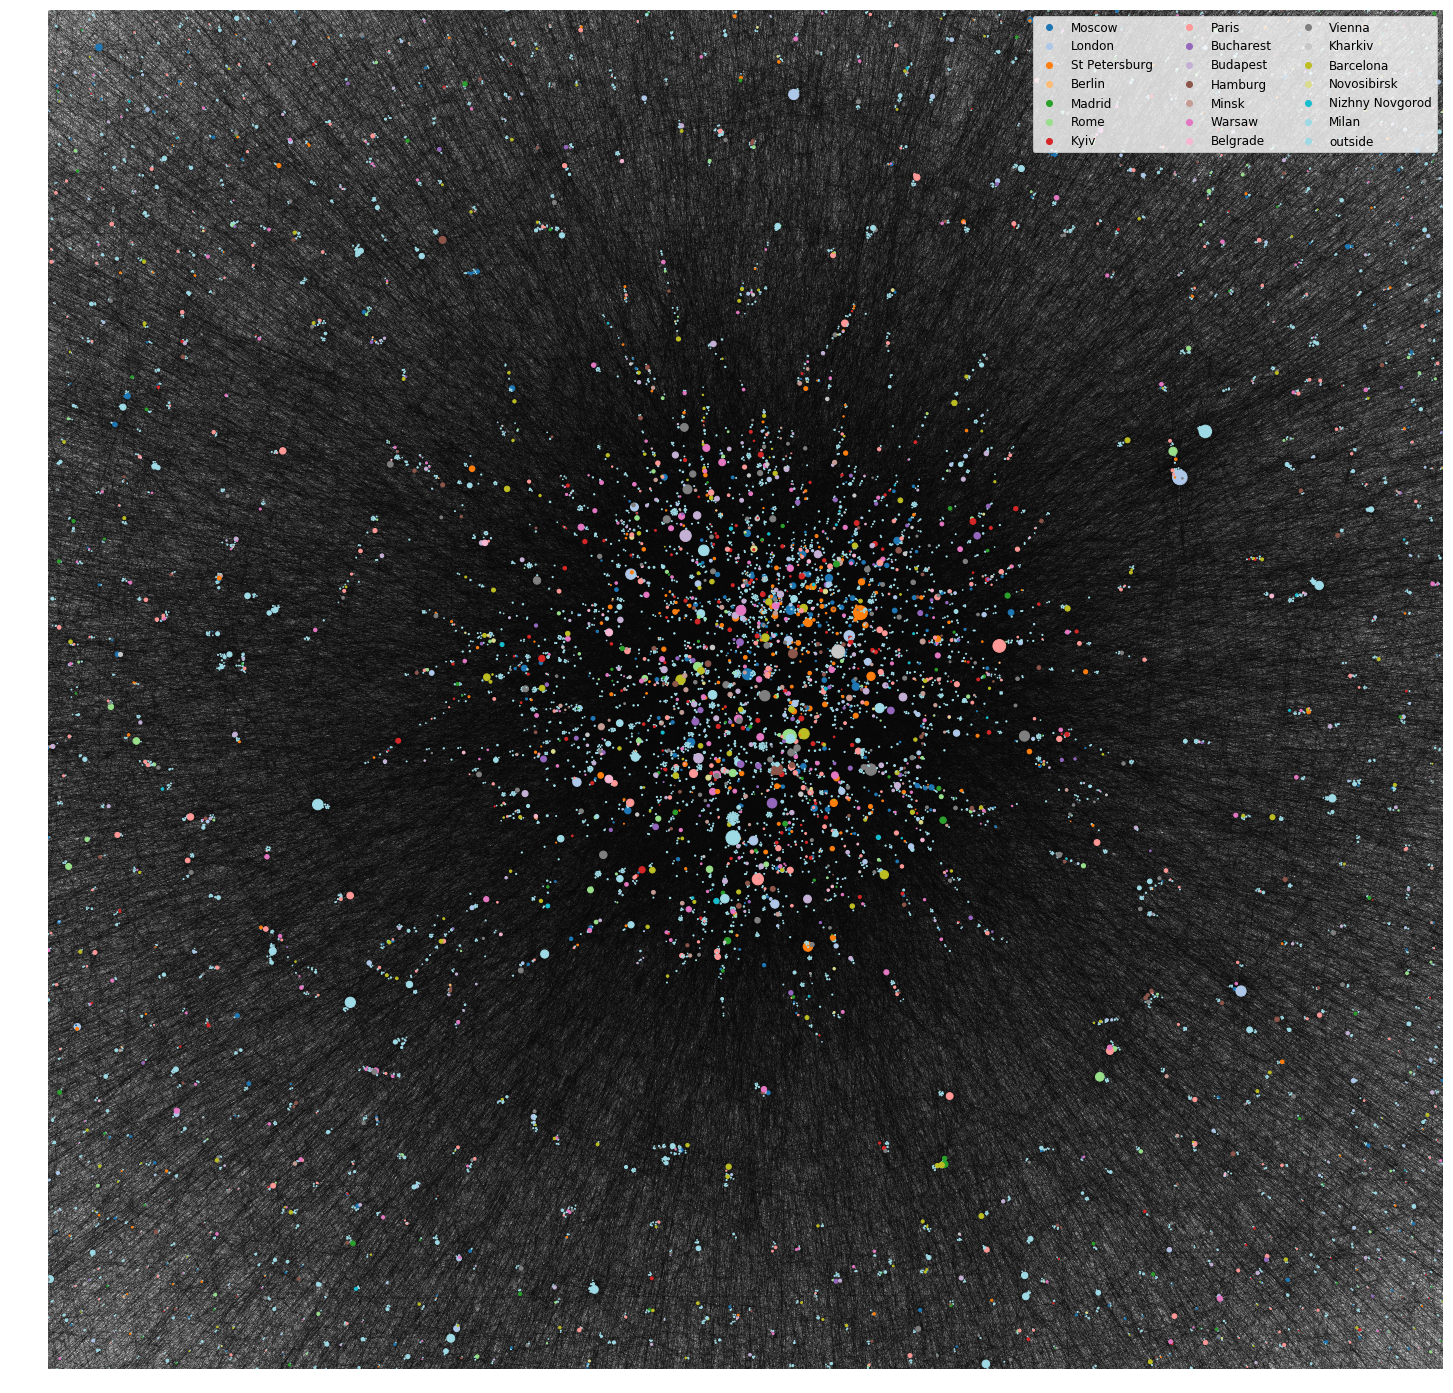

In [27]:
# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(1,1,1)
for label in legend_city  :
    ax.scatter([0],[0],color=citi_to_color_dict[label],label=label)

# Just fixed the color map
nx.draw_networkx(G_withSentValue,pos=positions,with_labels = False, width=0.02,node_size=[v[1] * 0.5 for v in d]
                 ,node_color=[v for k,v in node_to_color_dict.items()],ax=ax, labels=None, label=None)

plt.xlim(-5000,5000)
plt.ylim(-5000,5000)
# Setting it to how it was looking before.                                                                                                              
plt.axis('off')

plt.legend(
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)


plt.show()


In [17]:

# to try it out over night ;)



# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(1,1,1)
for label in legend_city  :
    ax.scatter([0],[0],color=citi_to_color_dict[label],label=label)

# Just fixed the color map
nx.draw_networkx(G_withSentValue,with_labels = False, width=0.02,node_size=[v[1] * 0.4 for v in d]
                 ,node_color=[v for k,v in node_to_color_dict.items()],ax=ax, labels=None, label=None)

plt.xlim(-3000,3000)
plt.ylim(-3000,3000)
# Setting it to how it was looking before.                                                                                                              
plt.axis('off')

plt.legend(
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-2b90fa2a71d8>, line 15)

### 3.1.User

#### 3.1.1. Initial Analysis

+ from where are the users? (Eike)
+ We have 10582 hosts that the based our analysis on
+ We have 96085 reviews extracted for that hosts.

In [307]:
# count how many nodes we have per each city and these one with empty feature of city if any:
# total number of nodes: 94831
nodes_city_counter = dict()

nodes_city_counter['outside'] = 1
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[1]['city'] in nodes_city_counter:
            nodes_city_counter[node[1]['city']] += 1
        else:
            nodes_city_counter[node[1]['city']] = 1
    else:
        nodes_city_counter['outside'] +=1
nodes_city_counter

{'Barcelona': 392,
 'Belgrade': 61,
 'Berlin': 788,
 'Bucharest': 120,
 'Budapest': 315,
 'Hamburg': 289,
 'Kharkiv': 68,
 'Kyiv': 364,
 'London': 496,
 'Madrid': 233,
 'Milan': 352,
 'Minsk': 149,
 'Moscow': 709,
 'Nizhny Novgorod': 56,
 'Novosibirsk': 54,
 'Paris': 870,
 'Rome': 251,
 'St Petersburg': 450,
 'Vienna': 386,
 'Warsaw': 465,
 'outside': 73857}

#### 3.1.2. Alternative Construction

+ What are the nodes and reviews in the goe representation of the network (Eike)


## 4. Basic Network Analysis

In [309]:
# validation of the data:
print('Number of all reviews: ',len(rev) )
userRevWithSentVal = rev.loc[ rev['sentimentValue'].notnull()]
print('Number of all reviews with sentiment: ',len(userRevWithSentVal))
print('Edges without sentiment: ', len(rev) - len(userRevWithSentVal) )
print('How many edges are unique ( from these with sentiment) ',len(G.edges),' / ',len(G_withSentValue.edges),'  not unique ( no of revisits ): ===>', len(userRevWithSentVal) -  len(G.edges) )
print('Number of all reviews we are using for analysis: ',len(G_withSentValue.edges))

Number of all reviews:  95270
Number of all reviews with sentiment:  86365
Edges without sentiment:  8905
How many edges are unique ( from these with sentiment)  84924  /  86365   not unique ( no of revisits ): ===> 1441
Number of all reviews we are using for analysis:  86365


### 4.1. Degree Distribution:

#### 4.1.1 Network degree (in, out, total) distribution:

In [310]:
# calculating degree distribution:

# in general ( in and out )
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

# in
in_degree_sequence = sorted([d for n, d in G_withSentValue.in_degree()], reverse=True)  # degree sequence
in_degreeCount = collections.Counter(in_degree_sequence)
in_deg, in_cnt = zip(*in_degreeCount.items())

# out
out_degree_sequence = sorted([d for n, d in G_withSentValue.out_degree()], reverse=True)  # degree sequence
out_degreeCount = collections.Counter(out_degree_sequence)
out_deg, out_cnt = zip(*out_degreeCount.items())

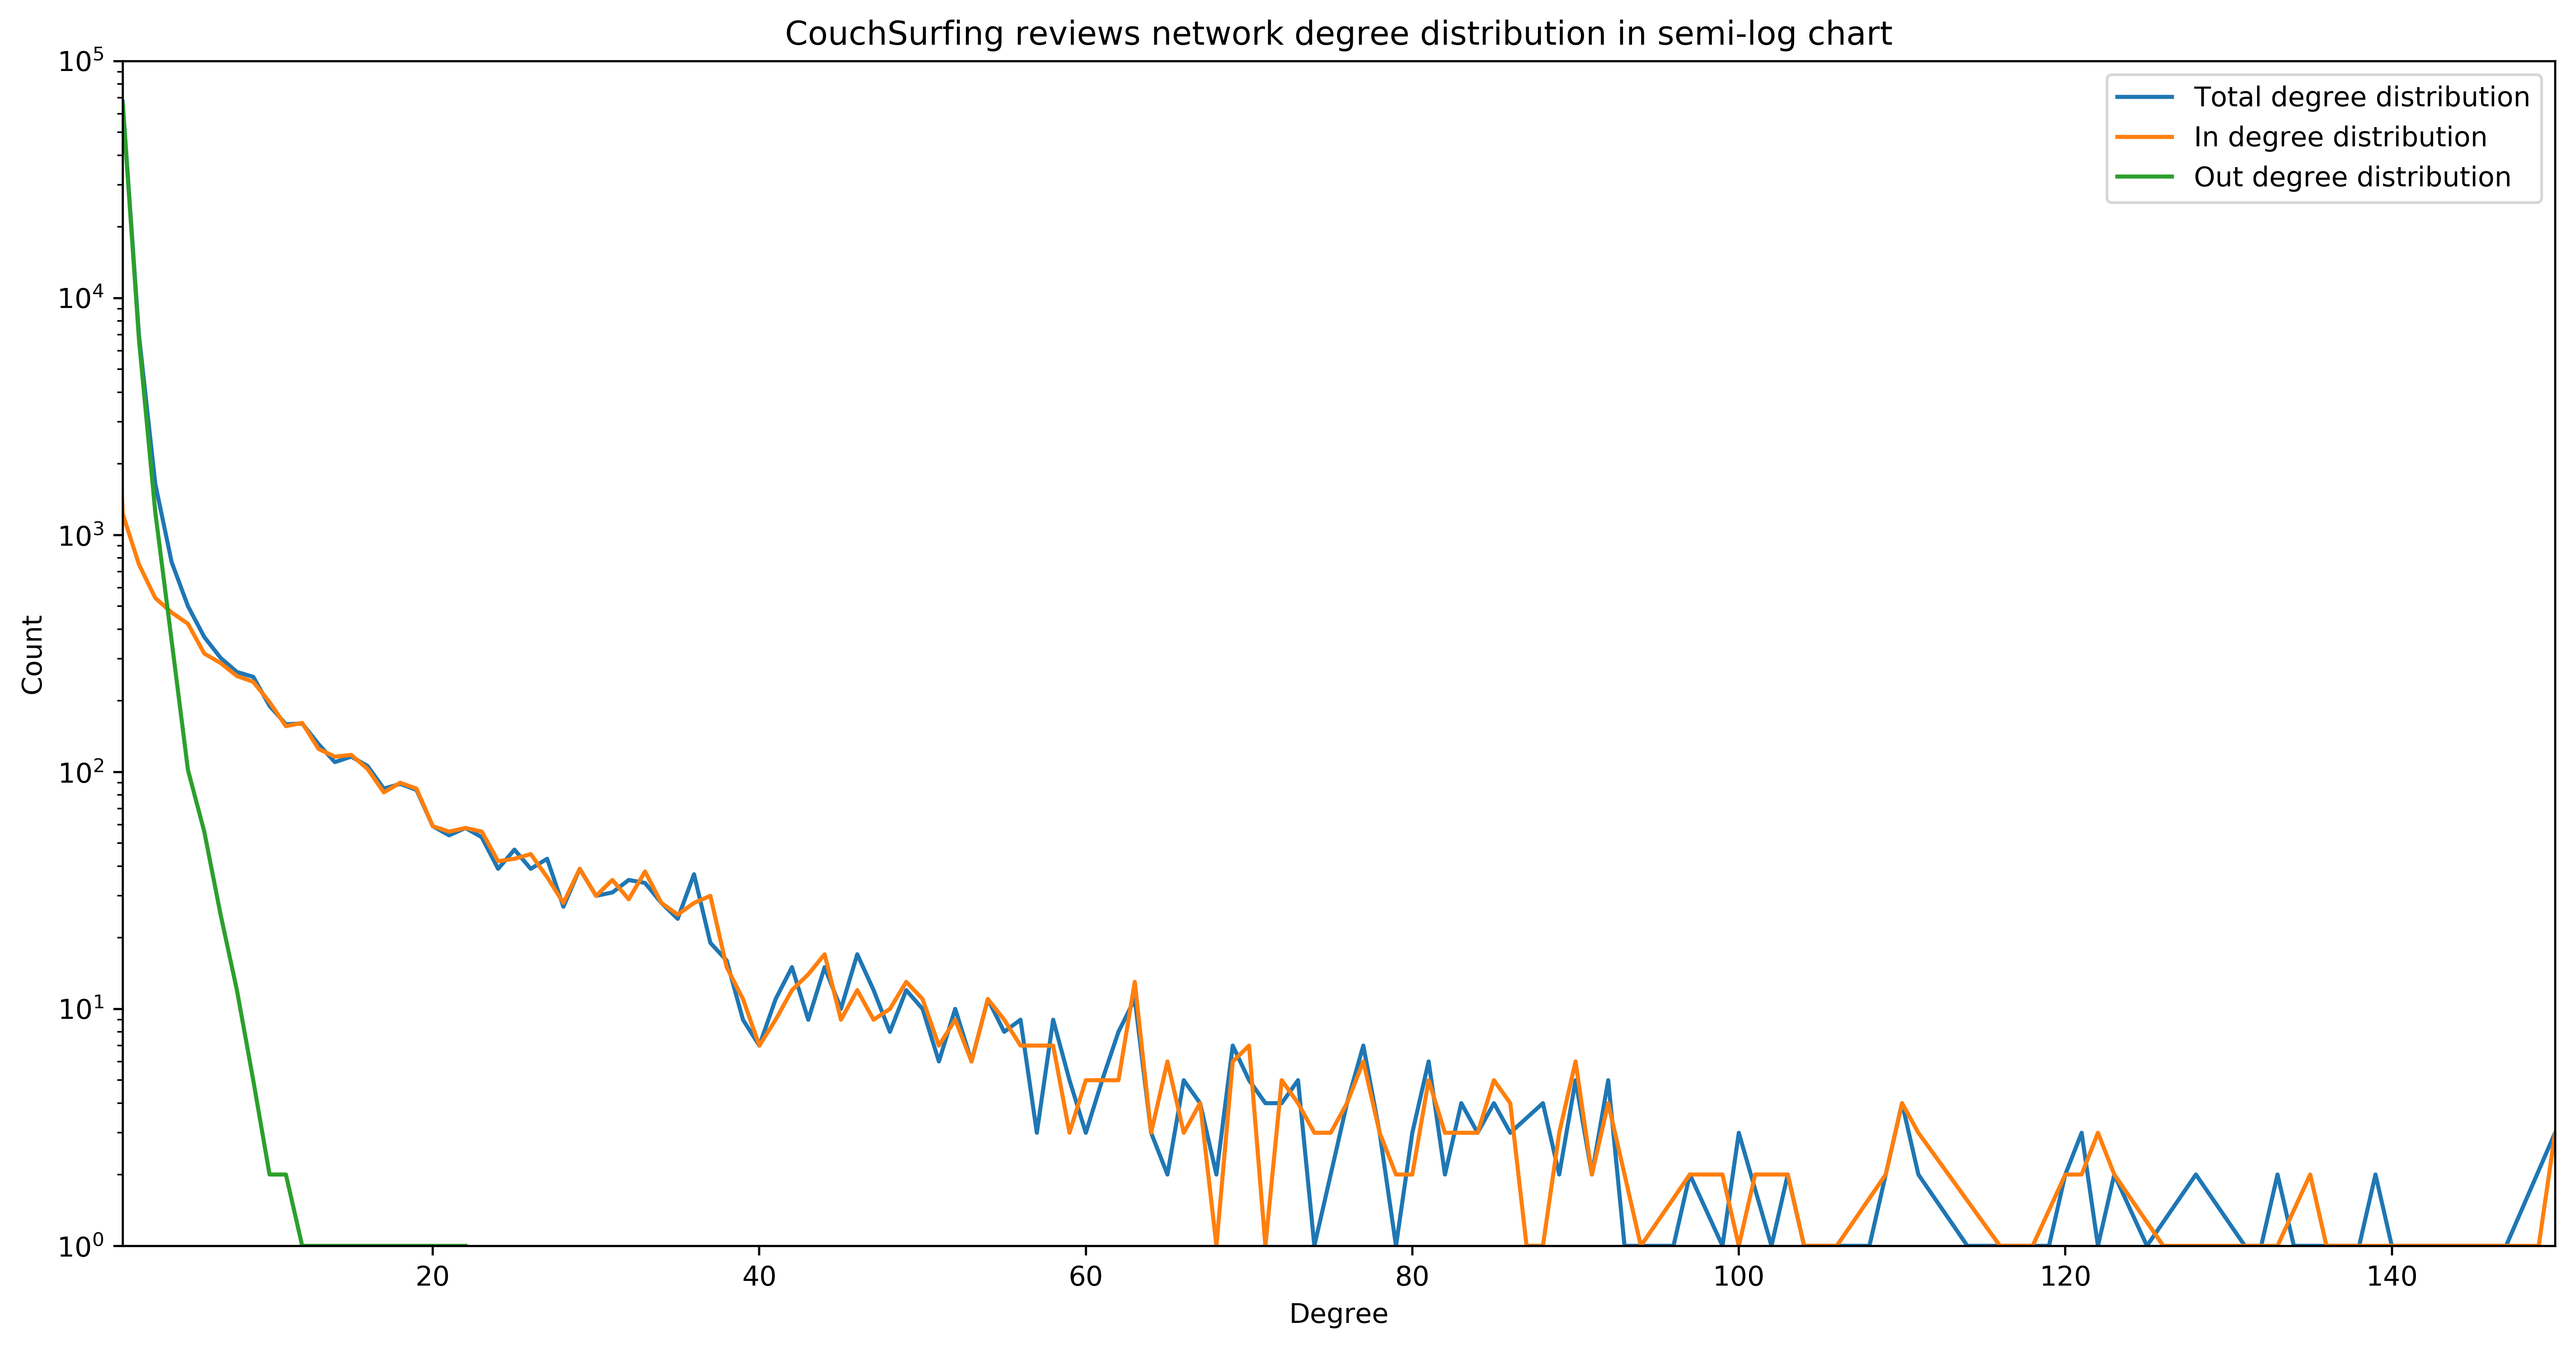

In [311]:
#4. Comparizon on semilog chart

plt.figure(figsize=(16, 8), dpi= 500)
#plt.bar(deg, cnt, width=0.80, color='b')
plt.semilogy(deg,cnt, label='Total degree distribution')
plt.semilogy(in_deg,in_cnt, label='In degree distribution')
plt.semilogy(out_deg,out_cnt, label='Out degree distribution')
plt.legend()
#fig= facecolor='w', edgecolor='w')
out_axes = plt.gca()
out_axes.set_xlim([1,150])
out_axes.set_ylim([1,100000])
plt.title("CouchSurfing reviews network degree distribution in semi-log chart")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.savefig('degree_dist_semi_log.png', dpi=500, transparent=True)
plt.show()

Because of high variety of degree distribution it's has been presented with semi-log scale.

In [312]:
# calculate nodes by cities
nodes_by_cities = dict()

nodes_by_cities['outside'] = ([],[])
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[1]['city'] not in nodes_by_cities:
            nodes_by_cities[node[1]['city']] = ([],[])
        tup = nodes_by_cities[node[1]['city']]
        tup[0].append(G_withSentValue.in_degree(node[0]))
        tup[1].append(G_withSentValue.out_degree(node[0])) 
    else:
        tup = nodes_by_cities['outside']
        tup[0].append(G_withSentValue.in_degree(node[0]))
        tup[1].append(G_withSentValue.out_degree(node[0]))

#### 4.1.2 Nodes' degree (in and out) comparison:

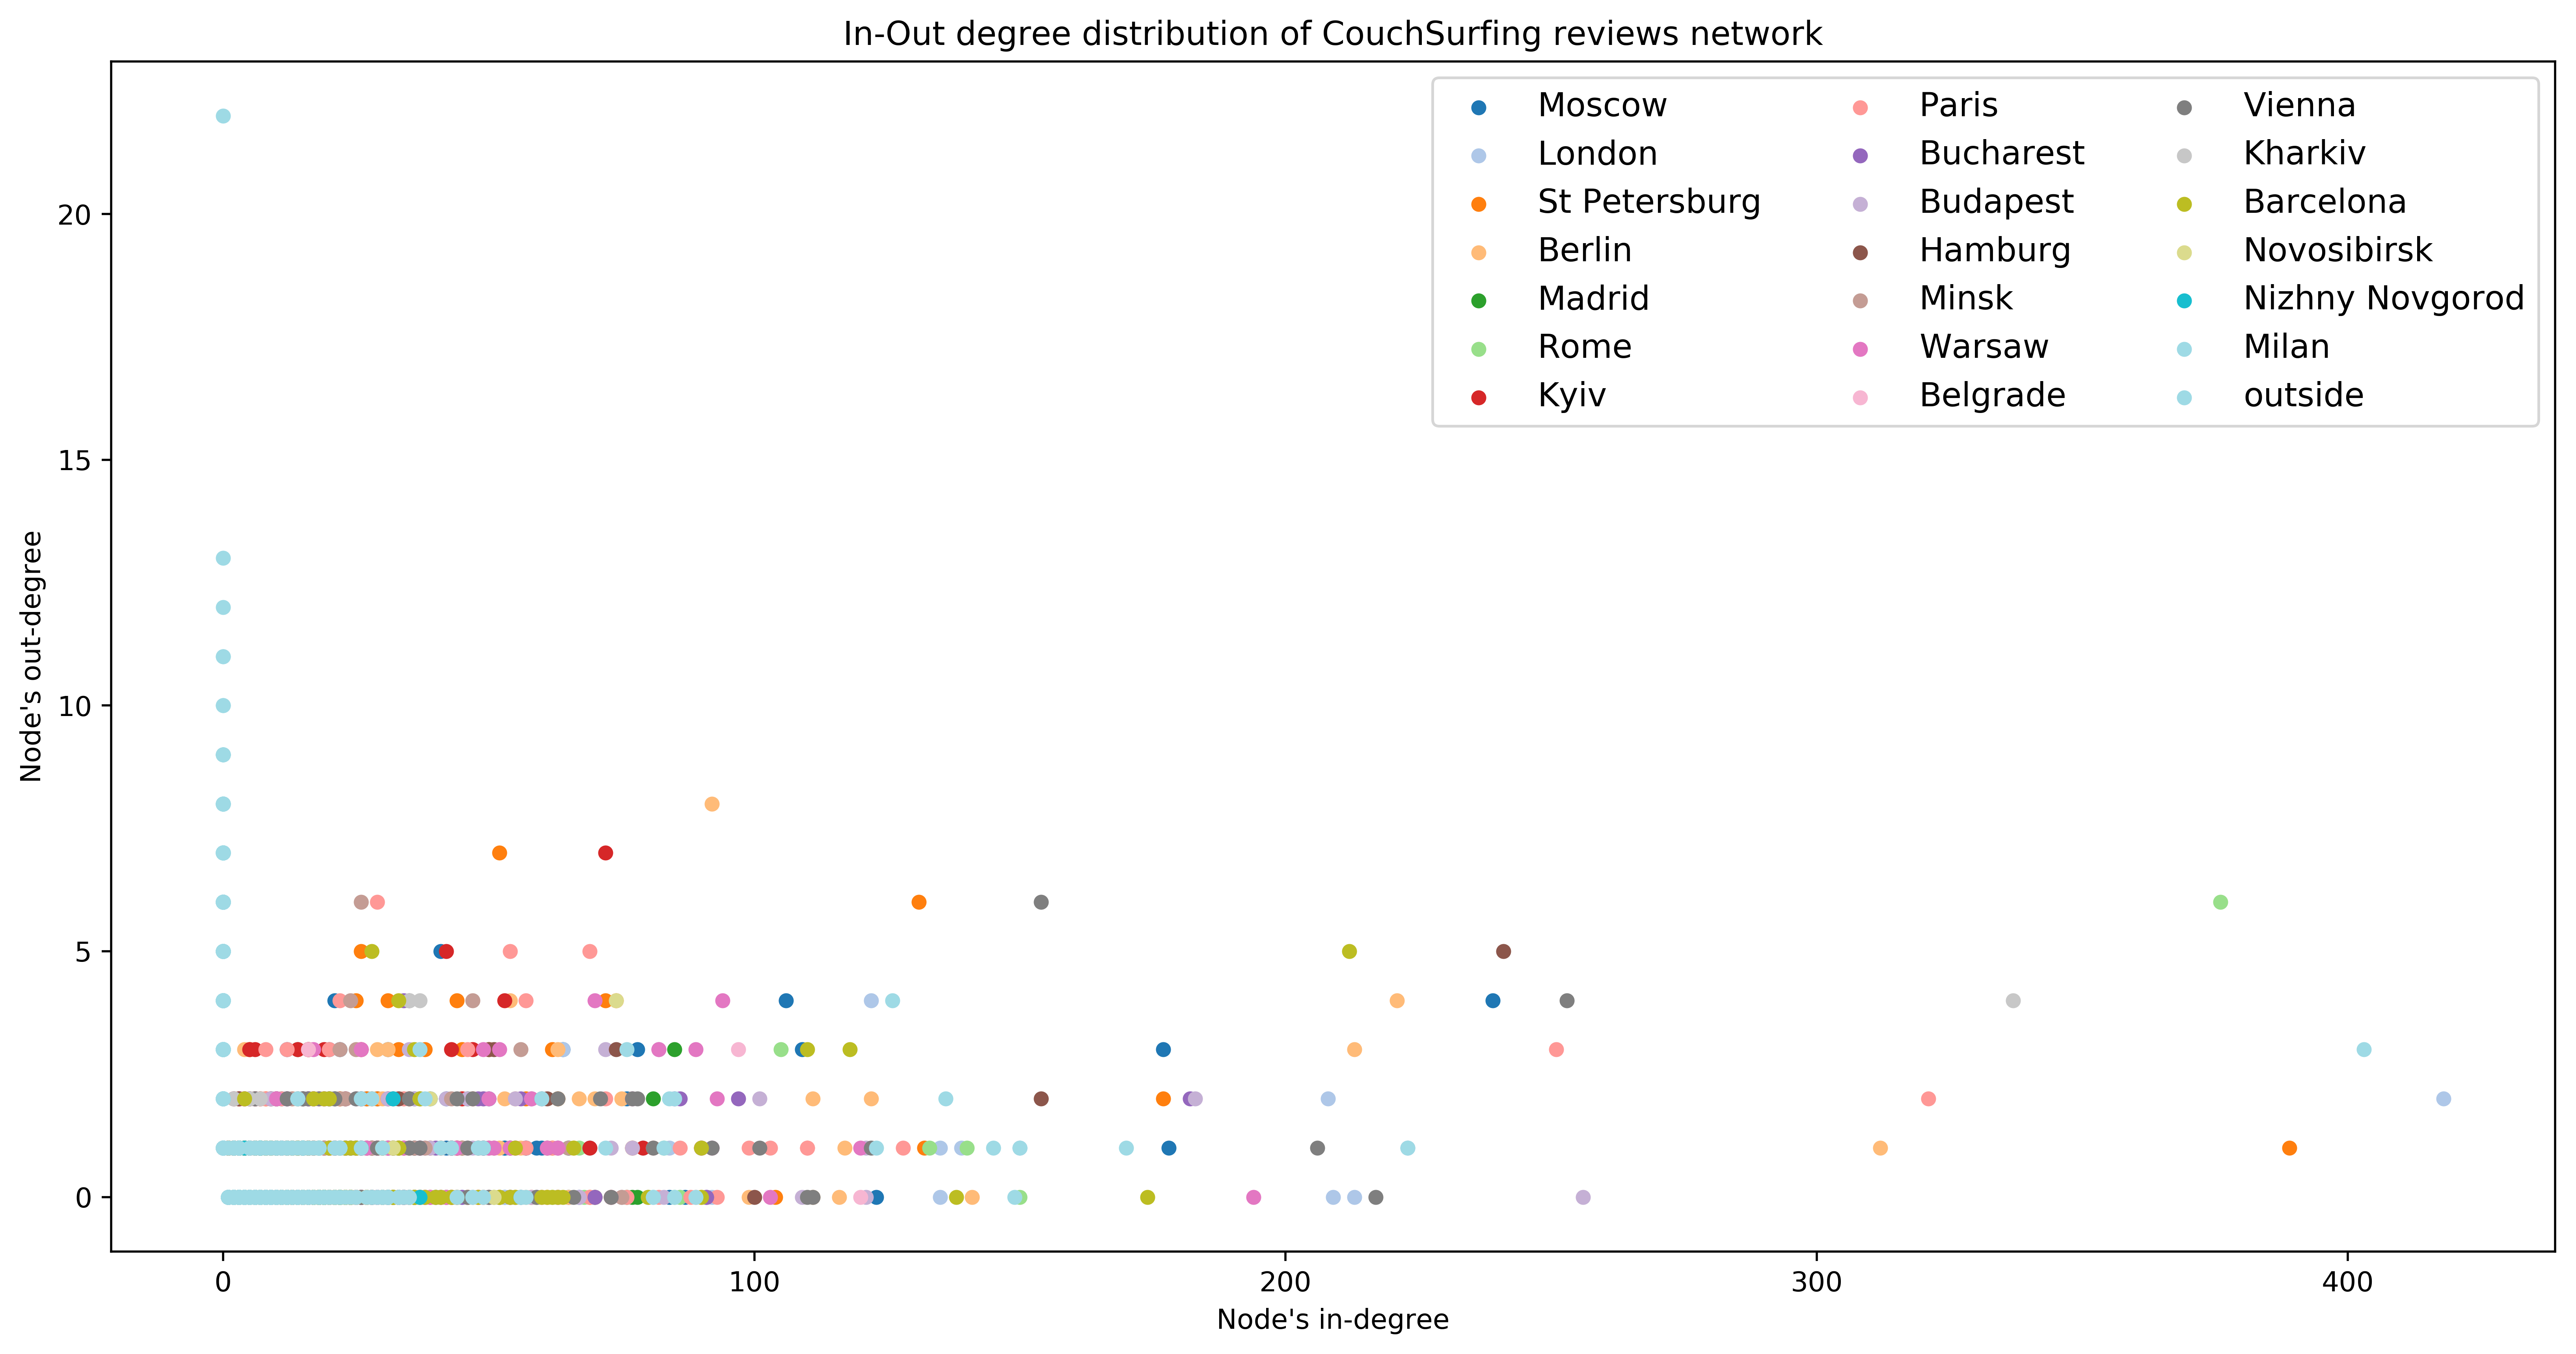

In [313]:
# scatter plot of in across out degree.
in_degree_values = []
out_degree_values = []
city_values = []

for node in G_withSentValue.nodes():
    in_degree_values.append(G_withSentValue.in_degree(node))
    out_degree_values.append(G_withSentValue.out_degree(node))
    
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        city_values.append(node[1]['city'] ) 
    else:
        city_values.append('outside')

plt.figure(figsize=(16, 8), dpi= 500)

scatter_list = []
for idx, city in enumerate(legend_city,start=0):
    scatter_list.append(plt.scatter(nodes_by_cities[city][0],nodes_by_cities[city][1], c=legend_col[idx] ,s=20))   

plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)

    
#plt.bar(deg, cnt, width=0.80, color='b')
#scatter, = plt.scatter(in_degree_values,out_degree_values, label='In-Out degree distribution', c=[city_to_color_dict[j] for j in city_values])
#plt.legend(tuple(legend_city),tuple([city_to_color_dict[j] for j in legend_city]))
plt.title("In-Out degree distribution of CouchSurfing reviews network")
plt.ylabel("Node's out-degree")
plt.xlabel("Node's in-degree")
plt.savefig('In-Out degree distribution of CouchSurfing reviews network.png' , dpi = 500, transparent=True)
plt.show()

In [314]:
nodes_by_cities

{'Barcelona': ([19,
   23,
   13,
   18,
   12,
   17,
   9,
   118,
   20,
   5,
   10,
   212,
   18,
   33,
   14,
   66,
   9,
   25,
   28,
   2,
   8,
   16,
   4,
   110,
   10,
   32,
   37,
   3,
   7,
   90,
   30,
   24,
   22,
   3,
   33,
   6,
   8,
   33,
   1,
   19,
   2,
   2,
   17,
   54,
   2,
   13,
   2,
   6,
   20,
   27,
   10,
   10,
   2,
   62,
   8,
   2,
   19,
   2,
   6,
   15,
   1,
   1,
   48,
   6,
   2,
   6,
   19,
   2,
   11,
   4,
   38,
   19,
   14,
   1,
   3,
   6,
   2,
   10,
   21,
   4,
   9,
   40,
   6,
   1,
   64,
   7,
   18,
   1,
   14,
   2,
   22,
   5,
   4,
   5,
   11,
   4,
   12,
   17,
   1,
   21,
   1,
   4,
   18,
   4,
   22,
   23,
   16,
   12,
   20,
   55,
   2,
   7,
   27,
   14,
   6,
   5,
   24,
   15,
   2,
   12,
   15,
   3,
   6,
   10,
   19,
   24,
   17,
   7,
   10,
   4,
   5,
   1,
   4,
   13,
   30,
   10,
   12,
   17,
   4,
   4,
   4,
   2,
   3,
   12,
   32,
   3,
   1,
   12,
   4,
   5,
   

Discussion:
How users are acting?

From the graph we can notice disproportion between maximum value of in and out degree. It can be explain becaus of small proportionally small quantity of hosts that data was extracted for (about 10000). After addidion of the reviews our network grows to and in the edn it has about 83000 nodes. We can't conclude any asumptions from that data. 

In [315]:
#tool to pick appropriate treshold:
h = 0
for s in in_degree_sequence:
    if s>83:
        h=h+1
h

114

In [316]:
#checking how many of nodes of the fighest degree are afrom what cities

g = dict()
treshold = 83

for city, values in nodes_by_cities.items():
    g[city] = 0
    for h in values[0]:
        if h > treshold:
            b = g[city]
            g[city] = b + 1
            
g

{'Barcelona': 7,
 'Belgrade': 2,
 'Berlin': 12,
 'Bucharest': 6,
 'Budapest': 6,
 'Hamburg': 3,
 'Kharkiv': 1,
 'Kyiv': 0,
 'London': 13,
 'Madrid': 1,
 'Milan': 13,
 'Minsk': 0,
 'Moscow': 9,
 'Nizhny Novgorod': 0,
 'Novosibirsk': 0,
 'Paris': 12,
 'Rome': 7,
 'St Petersburg': 5,
 'Vienna': 9,
 'Warsaw': 8,
 'outside': 0}

From what city the most times rated host come from (in terms of number of received rates)?

In 10 % of hosts with the biggest number of reviews there is the most people from : Milan (13), London(13), Paris(12), Berlin(12)

### 4.2. Power-laws degree distribution:

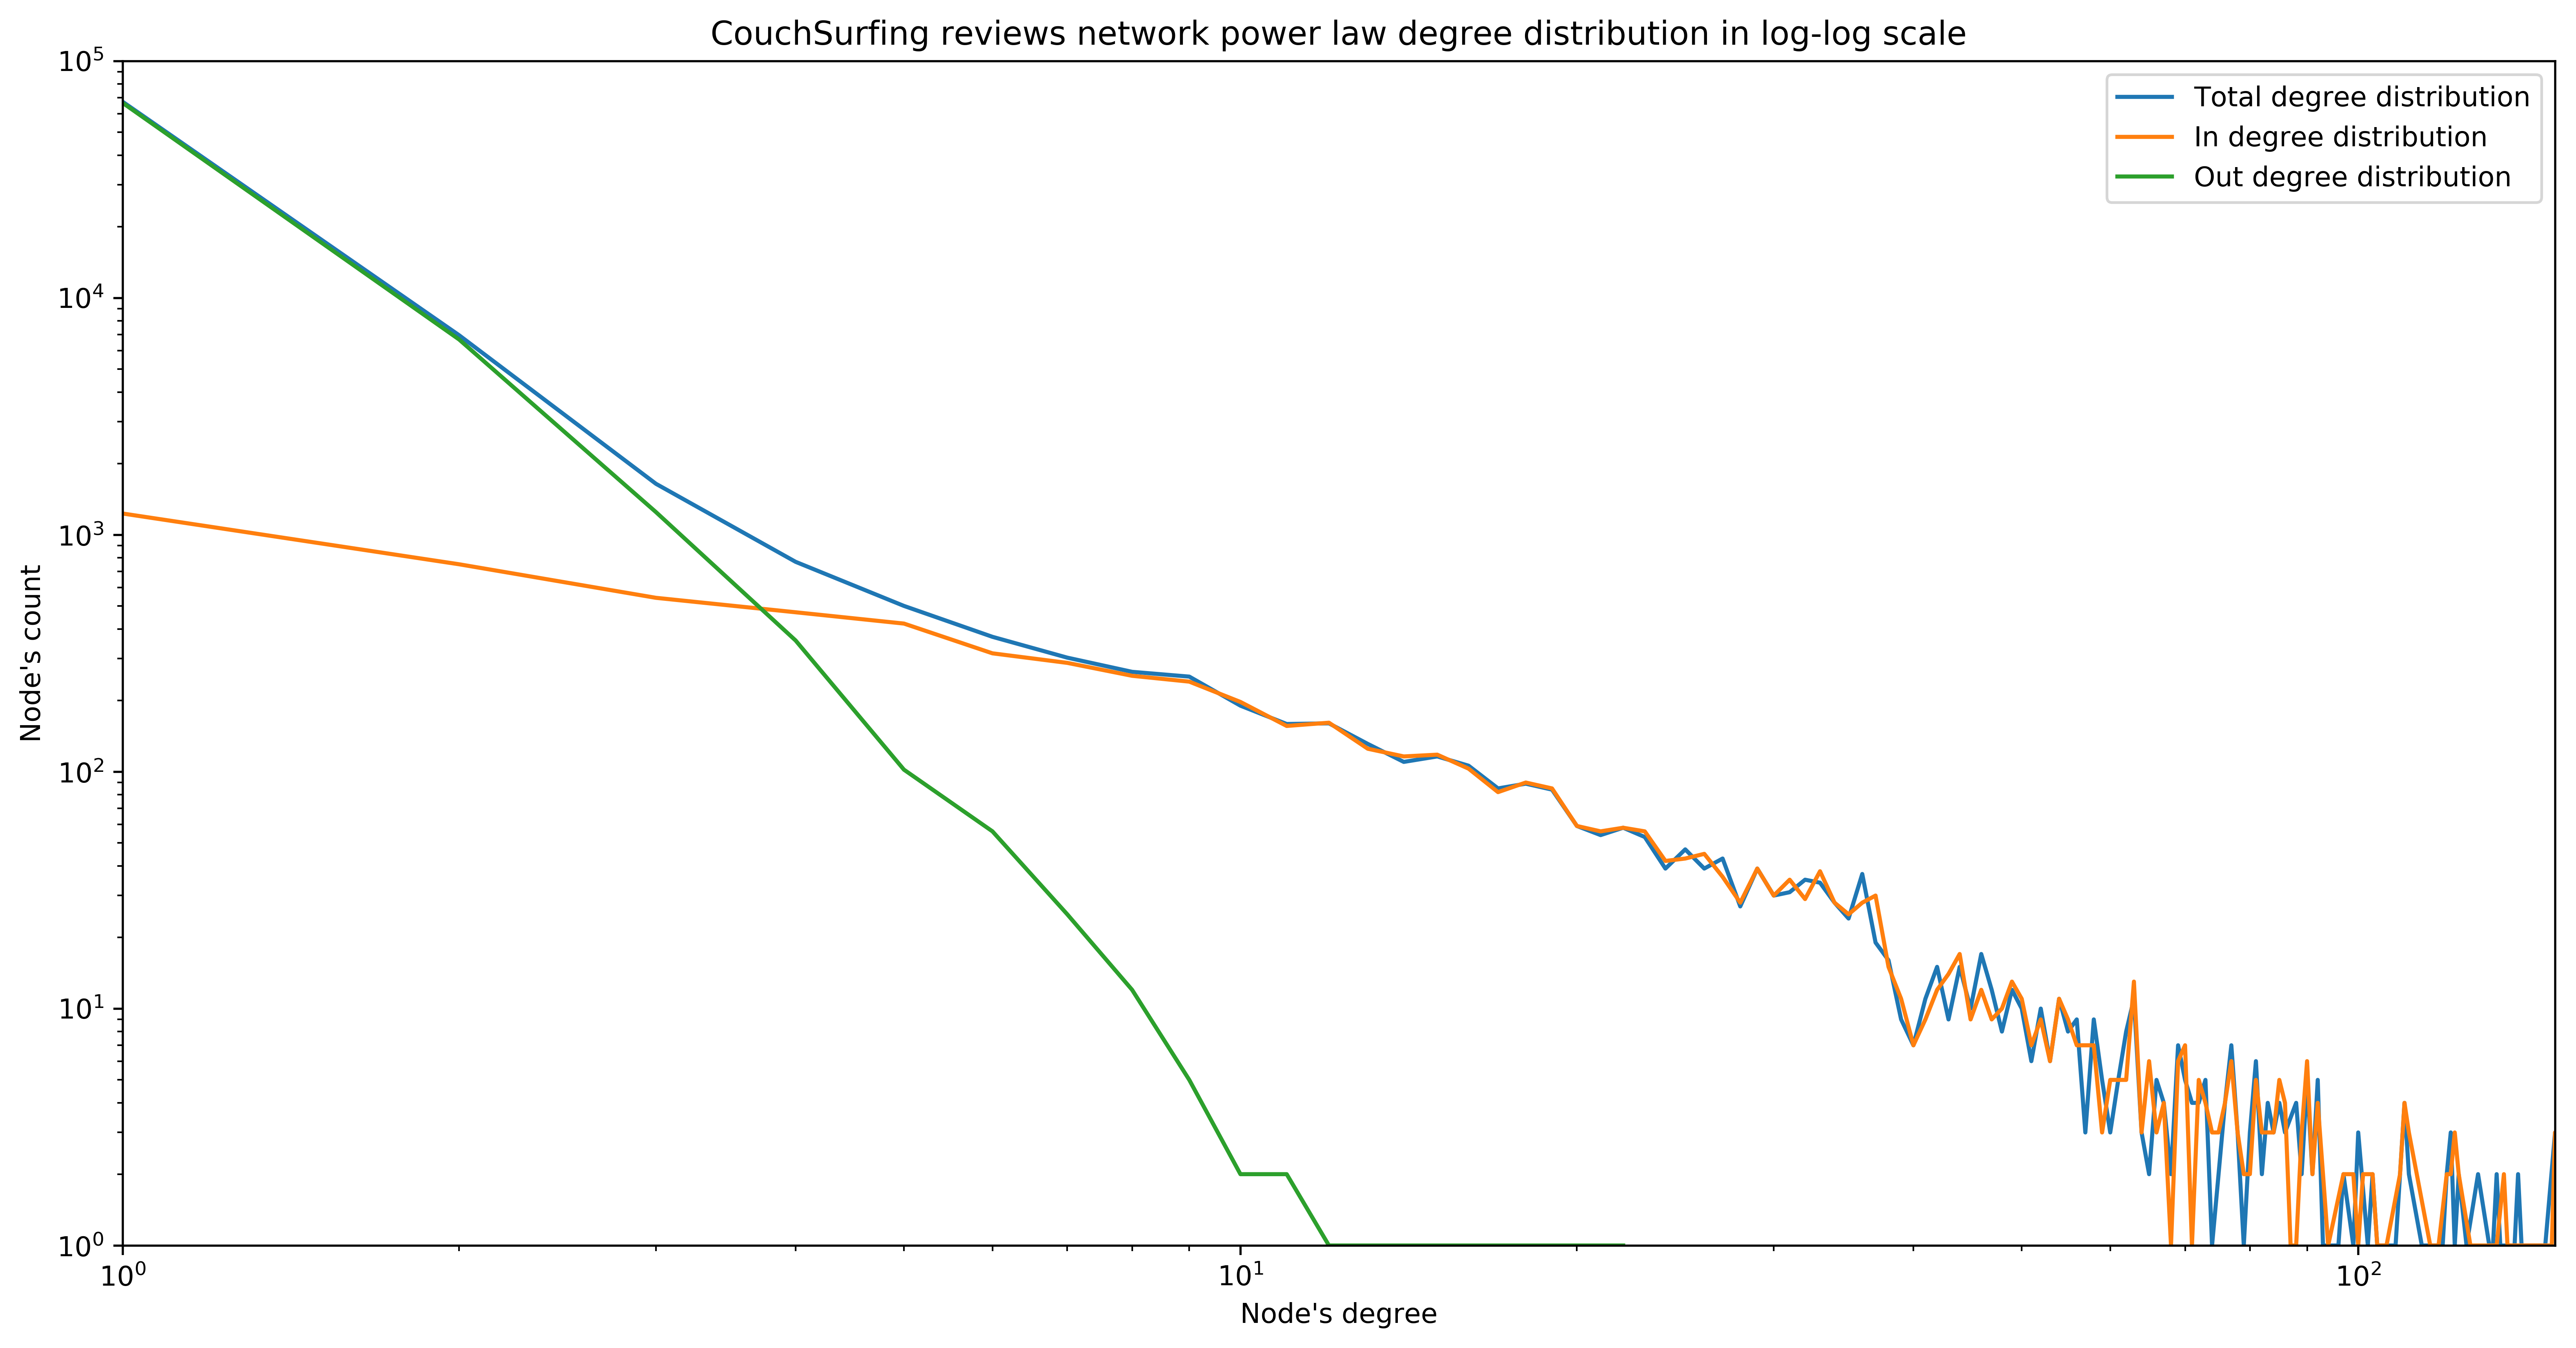

In [317]:
#5.Comparizon on loglog chart
plt.figure(figsize=(16, 8), dpi= 500)
#plt.bar(deg, cnt, width=0.80, color='b')
plt.loglog(deg,cnt, label='Total degree distribution')
plt.loglog(in_deg,in_cnt, label='In degree distribution')
plt.loglog(out_deg,out_cnt, label='Out degree distribution')
plt.legend()
#fig= facecolor='w', edgecolor='w')
out_axes = plt.gca()
out_axes.set_xlim([1,150])
out_axes.set_ylim([1,100000])
plt.title("CouchSurfing reviews network power law degree distribution in log-log scale")
plt.ylabel("Node's count")
plt.xlabel("Node's degree")
#ax.set_xticks([d + 0.4 for d in deg])
#ax.set_xticklabels(deg)
plt.savefig('CouchSurfing reviews network power law degree distribution.png' , dpi = 500, transparent=True)
plt.show()

What kind of network is it?

In the chart we can see that the degree distribution of CouchSurfing reviews network. It is a clear that this network is not random but scale-free network as it does not follow binominal but power law degree distribution. 

Which type of users are getting more reviews? Hosts or surfers? 

Moreover, we can notice that out and in degree distribution cross at some point. There is more surfers with low degree and more hosts with high degree distribution. It can be explained by fact that surfers ( out degree ) try that service sporadically but when they become hosts ( in degree ) then they start to receive reviews more often.

### 4.3\. Centrality

#### 4.3.1. Betweenness Centrality:

In [318]:
# for visualization purposes:
def getColorfromCmap(val): 
    cmap = cm.get_cmap('tab20') 
    return cmap(val)

legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]



  Number of nodes with betweenness centrality equal to 0:  80342 



  Number of nodes with betweenness centrality bigger than 0:  382 




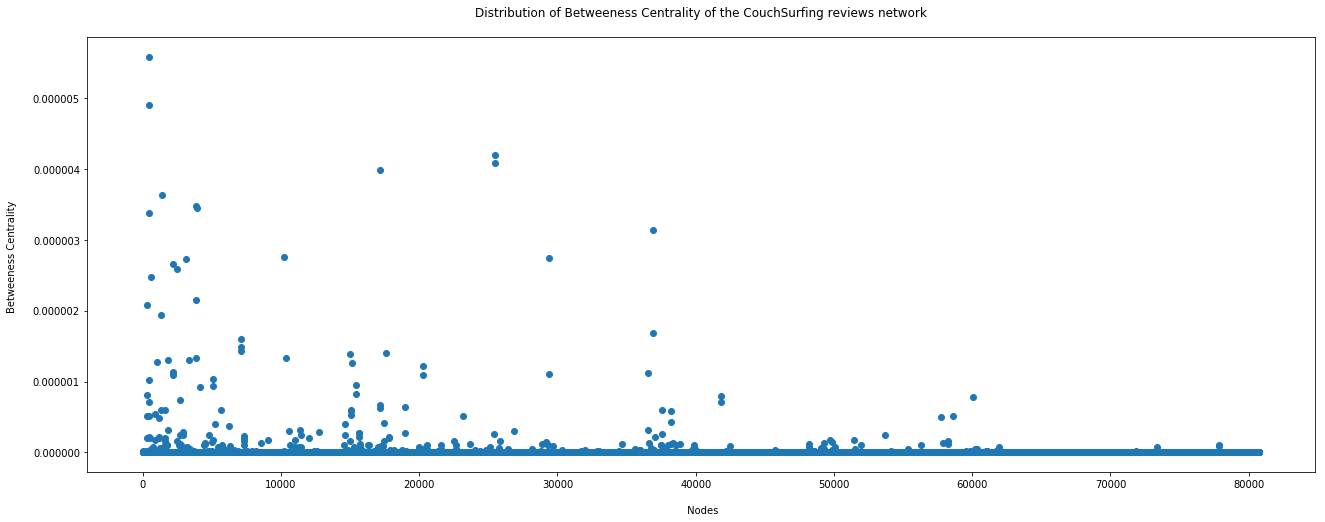

In [321]:
#plotting betweenness centrality of network

betweenness_centrality = nx.betweenness_centrality(G_withSentValue, k=1000)

no_bc_0 = list(betweenness_centrality.values()).count(0.0)
print("\n  Number of nodes with betweenness centrality equal to 0: ",no_bc_0,"\n\n")
print("\n  Number of nodes with betweenness centrality bigger than 0: ",len(list(betweenness_centrality.values()))-no_bc_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

In [ ]:
#are you sure unidirected!!!!

#plotting betweenness centrality of network but unidirected

#betweenness_centrality = nx.betweenness_centrality(G_withSentValue, k=1000)
betweenness_centrality_unidirected = nx.betweenness_centrality(G_withSentValue.to_undirected(), k=100)

no_bc_u_0 = list(betweenness_centrality_unidirected.values()).count(0.0)
print("\n  Number of nodes with betweenness centrality equal to 0: ",no_bc_u_0,"\n\n")
print("\n  Number of nodes with betweenness centrality bigger than 0: ",len(list(betweenness_centrality_unidirected.values()))-no_bc_u_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality_unidirected.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

In [322]:
# calculation of the distribution of centrality by different cities:

node_to_city_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[0] not in node_to_city_dict:
            node_to_city_dict[node[0]] = node[1]['city']
    else:
        node_to_city_dict[node[0]] = 'outside'
        
beetweennes_centrality_nodes_by_city = dict()
for key, value in betweenness_centrality.items():
    if value > 0.0 :
        city = node_to_city_dict[key]
        if city not in beetweennes_centrality_nodes_by_city:
            beetweennes_centrality_nodes_by_city[city] = []
        beetweennes_centrality_nodes_by_city[city].append(tuple([key, value]))   

for key1, value in beetweennes_centrality_nodes_by_city.items():
    value.sort(key=lambda x: x[1], reverse=True)

In [323]:
for key, value in beetweennes_centrality_nodes_by_city.items():
    print(key, ' : ', value[0][1] )
    
beetweennes_centrality_nodes_by_city['Moscow']

Moscow  :  5.574757496337769e-06
Budapest  :  9.539029493733517e-07
Berlin  :  4.088155497314364e-06
Kharkiv  :  1.3874951990885115e-06
St Petersburg  :  1.3007767491454795e-06
Paris  :  4.905786596777237e-06
Kyiv  :  3.98904869737947e-06
London  :  2.7254369982095762e-06
Warsaw  :  4.187262297249258e-06
Milan  :  1.0901747992838305e-06
outside  :  3.716504997558513e-08
Novosibirsk  :  3.629786547615481e-06
Vienna  :  1.3379417991210646e-06
Minsk  :  3.4439612977375553e-06
Rome  :  2.5891651482990974e-06
Belgrade  :  2.143184548592076e-06
Barcelona  :  3.1342525479410127e-06
Hamburg  :  2.737825348201438e-06
Bucharest  :  1.4866019990234053e-06
Madrid  :  3.716504997558513e-08
Nizhny Novgorod  :  9.910679993489368e-08


[(2004013575, 5.574757496337769e-06),
 (2000347000, 3.4811263477131403e-06),
 (2002955433, 1.9325825987304267e-06),
 (3644180, 1.5980971489501605e-06),
 (45281, 1.2760000491617562e-06),
 (880760, 1.1397281992512774e-06),
 (1007560704, 1.0901747992838305e-06),
 (2002969804, 1.0158446993326602e-06),
 (2791380, 9.415145993814899e-07),
 (3918396, 8.052427494710111e-07),
 (822436, 7.433009995117026e-07),
 (435129, 3.964271997395747e-07),
 (2005626227, 3.2209709978840447e-07),
 (1000153053, 2.601553498290959e-07),
 (2596672, 2.4776699983723417e-07),
 (2003425140, 2.2299029985351078e-07),
 (1219678, 2.1060194986164905e-07),
 (2004431404, 1.7343689988606393e-07),
 (1994736, 1.6104854989420223e-07),
 (2284225, 1.6104854989420223e-07),
 (2005187306, 1.6104854989420223e-07),
 (1001885315, 1.1149514992675539e-07),
 (2000986491, 9.910679993489368e-08),
 (4387608, 9.910679993489368e-08),
 (2001446313, 9.910679993489368e-08),
 (370083, 8.671844994303197e-08),
 (2003776949, 7.433009995117025e-08),
 (2

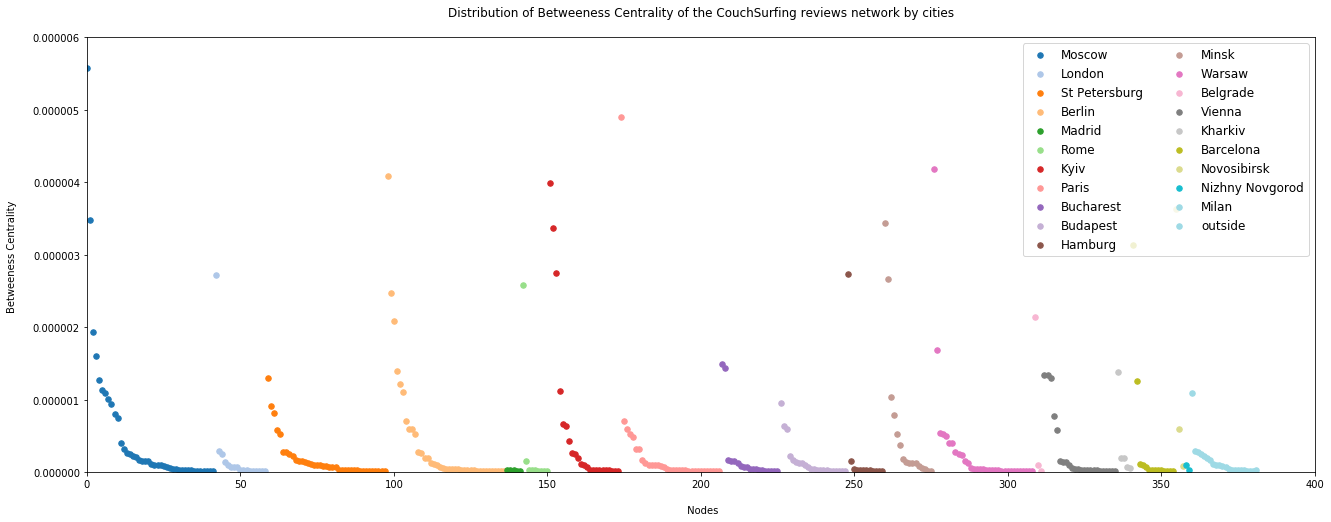

In [328]:
plt.figure(figsize = (22,8))
 
    
scatter_list = []
h = 0
for idx, city in enumerate(legend_city,start=0):
    if city not in beetweennes_centrality_nodes_by_city:
            beetweennes_centrality_nodes_by_city[city] = []
    bc_values = [ el[1] for el in beetweennes_centrality_nodes_by_city[city]]
    scatter_list.append(plt.scatter( range(h, h + len(bc_values)), bc_values , c=legend_col[idx], s=30 )) 
    h = h + len(bc_values)
    
plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=2,
           fontsize=12)

out_axes = plt.gca()
out_axes.set_xlim([0,400])
out_axes.set_ylim([0,0.000006])

plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network by cities\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.savefig('hostes_netweenness_centrality_mesures.png' , dpi = 500, transparent=True)
plt.show()

In [329]:
# get relevnt nodes by city:
relevant_nodes = []
for node, bc in betweenness_centrality.items():
    if bc > 0.0:
        relevant_nodes.append((node, bc ))
        
G_bc = nx.Graph(G_withSentValue.subgraph([x[0] for x in relevant_nodes]))
        
color_map_nodes = []
for node in G_bc.nodes(data=True):
    if node[1]:
        color_map_nodes.append(citi_to_color_dict[node[1]['city']])
    else:
        color_map_nodes.append(citi_to_color_dict['outside'])
        
relevant_edges = []

for u,v,no in G_withSentValue.edges:
    if betweenness_centrality[u] > 0.00 and betweenness_centrality[v] > 0.00:
        relevant_edges.append((u,v))
print(len(relevant_edges))
    
G_bc.add_edges_from( relevant_edges )

441


In [330]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=False)


positions_centrality = forceatlas2.forceatlas2_networkx_layout(G_bc, pos=None, iterations=10)

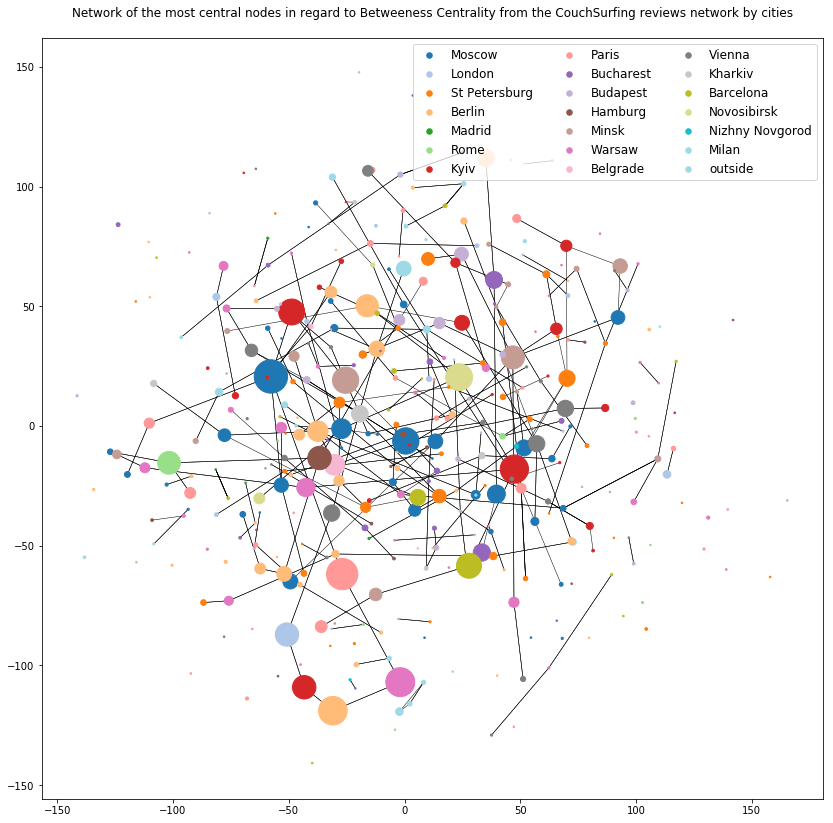

In [331]:
#create edges that connect relevant nodes concercing betweenness centrality

plt.figure(1,figsize=(14,14))

nx.draw_networkx_nodes(G_bc, pos = positions_centrality,  node_color = color_map_nodes,node_size=[x[1]* 200000000 for x in relevant_nodes], with_labels=True)
nx.draw_networkx_edges(G_bc,positions_centrality,edgelist = relevant_edges, edge_color='black', width = 0.5)

plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)

plt.title("Network of the most central nodes in regard to Betweeness Centrality from the CouchSurfing reviews network by cities\n")
plt.savefig('Network_of_the_most_central_nodes_in_regard_to_Betweeness_Centrality.png', transparent = True, dpi = 500)
plt.show()

Who are the most active users?

We may notice that the most central users are mostly people from Eastern European cities like Moscow, St Petersburg, Kyiv, Warsaw, Kharkiv and Minsk. But we can notice some nodes from Budapest or Barcelona The most central node is from Minsk.
It is like that because people from Eastern Europe beside being a host they are also more often a surfers. Thanks to that they become a node in the graph that is used more times while calculation paths.

#### 4.3.2 Eigenvector Centrality

In [332]:
eigenvector_centrality = nx.eigenvector_centrality(G_withSentValue)

no_ec_0 = list(eigenvector_centrality.values()).count(0.0)
print("\n  Number of nodes with Eigenvector Centrality equal to 0: ",no_ec_0,"\n\n")
print("\n  Number of nodes with Eigenvector Centrality bigger than 0: ",len(list(eigenvector_centrality.values()))-no_ec_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(eigenvector_centrality.values()),'o') 
plt.title("Distribution of Eigenvector Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Eigenvector Centrality \n")
plt.show()

NetworkXNotImplemented: not implemented for multigraph type

#### 4.3.3 Degree Centrality

#### 4.3.3.1 In-Degree Centrality


  Number of nodes with Eigenvector Centrality equal to 0:  73841 



  Number of nodes with Eigenvector Centrality bigger than 0:  6883 




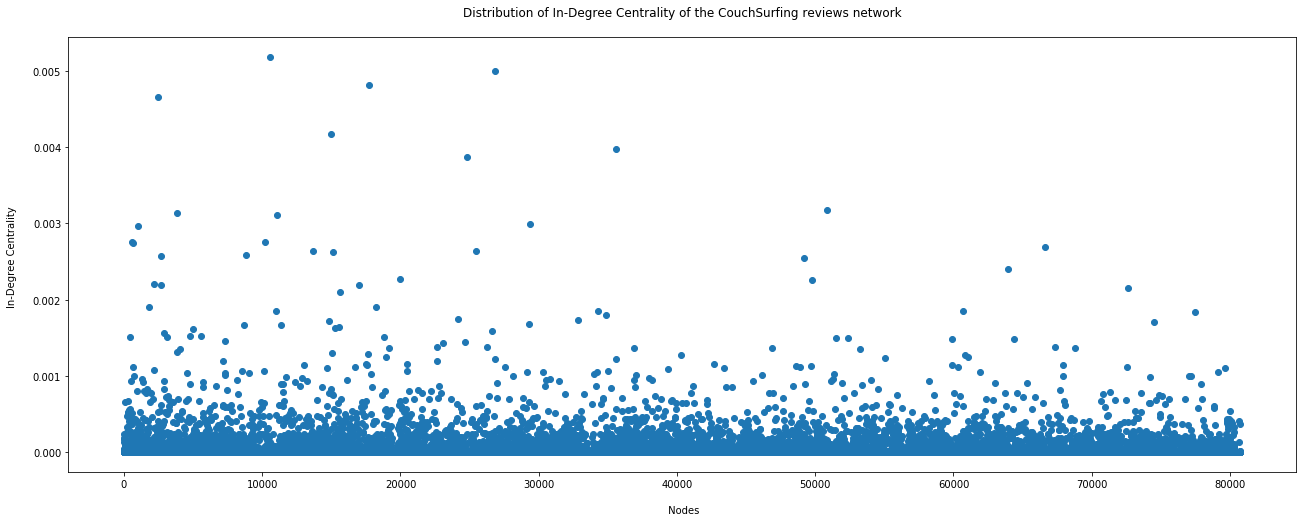

In [333]:
in_degree_centrality = nx.in_degree_centrality(G_withSentValue)

no_idc_0 = list(in_degree_centrality.values()).count(0.0)
print("\n  Number of nodes with Eigenvector Centrality equal to 0: ",no_idc_0,"\n\n")
print("\n  Number of nodes with Eigenvector Centrality bigger than 0: ",len(list(in_degree_centrality.values()))-no_idc_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(in_degree_centrality.values()),'o') 
plt.title("Distribution of In-Degree Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("In-Degree Centrality \n")
plt.show()

In [334]:
# calculation of the distribution of centrality by different cities:
   
in_degree_centrality_nodes_by_city = dict()
for key, value in in_degree_centrality.items():
    try:
        if value > 0.0005 : 
            city = node_to_city_dict[key]
            if city not in in_degree_centrality_nodes_by_city:
                in_degree_centrality_nodes_by_city[city] = []
            in_degree_centrality_nodes_by_city[city].append(tuple([key, value]))   
    except TypeError:
        print(key, value)
for key1, value in in_degree_centrality_nodes_by_city.items():
    value.sort(key=lambda x: x[1], reverse=True)

In [335]:

bc_sorted_by_value = sorted(in_degree_centrality.items(), key=lambda kv: kv[1], reverse=True)
print('Top 10 users by Betweenness Centrality')
bc_sorted_by_value[:10]

Top 10 users by Betweenness Centrality


[(961114, 0.00517820199943015),
 (1333459, 0.004992381353517585),
 (276627, 0.004818948750665857),
 (1307671, 0.004657904190874967),
 (1492572, 0.0041747705115022975),
 (305034, 0.003976561822528895),
 (818091, 0.0038650694349813557),
 (1002589164, 0.003171339023574446),
 (1000397506, 0.003134174894391933),
 (218222, 0.0031093988082702573)]

In [336]:
for key, value in in_degree_centrality_nodes_by_city.items():
    print(key, ' : ', value[0][1] )
    
in_degree_centrality_nodes_by_city['Moscow']

Moscow  :  0.0029607422915402053
Minsk  :  0.0009291032295628259
Berlin  :  0.0038650694349813557
St Petersburg  :  0.004818948750665857
Paris  :  0.003976561822528895
London  :  0.00517820199943015
Madrid  :  0.0010529836601712026
Novosibirsk  :  0.0009167151865019882
Vienna  :  0.003134174894391933
Rome  :  0.004657904190874967
Milan  :  0.004992381353517585
Kyiv  :  0.0009786554018061766
Budapest  :  0.003171339023574446
Warsaw  :  0.0024032803538025097
Bucharest  :  0.0022546238370724577
Barcelona  :  0.002626265128897588
Hamburg  :  0.0029855183776618804
Kharkiv  :  0.0041747705115022975
Belgrade  :  0.0014865651673005215
Nizhny Novgorod  :  0.00069373041140691


[(45281, 0.0029607422915402053),
 (880760, 0.002205071664829107),
 (822436, 0.002192683621768269),
 (554625, 0.0015237292964830344),
 (2652605, 0.001350296693631307),
 (2000347000, 0.001313132564448794),
 (214516, 0.001114923875475391),
 (1678617, 0.0010777597462928782),
 (3985430, 0.001040595617110365),
 (2002955433, 0.0009662673587453389),
 (1219678, 0.0009414912726236636),
 (1845933, 0.0008671630142586376),
 (407368, 0.0008299988850761245),
 (1003833208, 0.0008052227989544491),
 (1003134771, 0.0008052227989544491),
 (1910191, 0.0008052227989544491),
 (2005626227, 0.0007928347558936114),
 (1005300093, 0.0007804467128327738),
 (3109052, 0.0007432825836502608),
 (4990682, 0.0007308945405894231),
 (1003736711, 0.0007061184544677477),
 (1739082, 0.0007061184544677477),
 (2001446313, 0.0006689543252852347),
 (1000754645, 0.000656566282224397),
 (1391228, 0.000656566282224397),
 (1002101911, 0.000656566282224397),
 (2596672, 0.000619402153041884),
 (1264664, 0.0005450738946768579),
 (31264

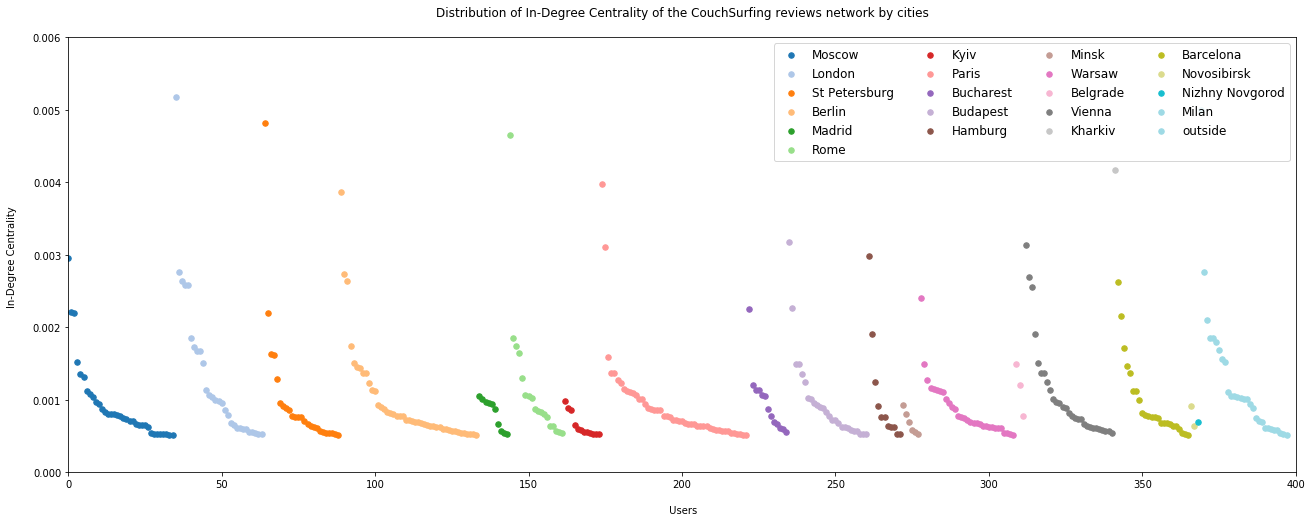

In [339]:
plt.figure(figsize = (22,8))
 
    
in_deg_scatter_list = []
h = 0
for idx, city in enumerate(legend_city,start=0):
    if city not in in_degree_centrality_nodes_by_city:
            in_degree_centrality_nodes_by_city[city] = []
    bc_values = [ el[1] for el in in_degree_centrality_nodes_by_city[city]]
    in_deg_scatter_list.append(plt.scatter( range(h, h + len(bc_values)), bc_values , c=legend_col[idx], s=30 )) 
    h = h + len(bc_values)
    
plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=12)

out_axes = plt.gca()
out_axes.set_xlim([0,400])
out_axes.set_ylim([0,0.006])

plt.title("Distribution of In-Degree Centrality of the CouchSurfing reviews network by cities\n")
plt.xlabel("\n Users")
plt.ylabel("In-Degree Centrality \n")
plt.savefig('users_in_degree_centrality_mesures.png' , dpi = 500, transparent=True)
plt.show()

In [349]:
# get relevnt nodes by city:
in_relevant_nodes = []
for node, bc in in_degree_centrality.items():
    if bc > 0.0:
        in_relevant_nodes.append((node, bc ))
        
G_id = nx.Graph(G_withSentValue.subgraph([x[0] for x in in_relevant_nodes]))
        
in_color_map_nodes = []
for node in G_bc.nodes(data=True):
    if node[1]:
        in_color_map_nodes.append(citi_to_color_dict[node[1]['city']])
    else:
        in_color_map_nodes.append(citi_to_color_dict['outside'])
        
in_relevant_edges = []

for u,v,no in G_withSentValue.edges:
    if in_degree_centrality[u] > 0.00 and in_degree_centrality[v] > 0.00:
        in_relevant_edges.append((u,v))
print(len(in_relevant_edges))
    
G_id.add_edges_from( in_relevant_edges )

1742


In [345]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=False)


positions_centrality = forceatlas2.forceatlas2_networkx_layout(G_id, pos=None, iterations=10)

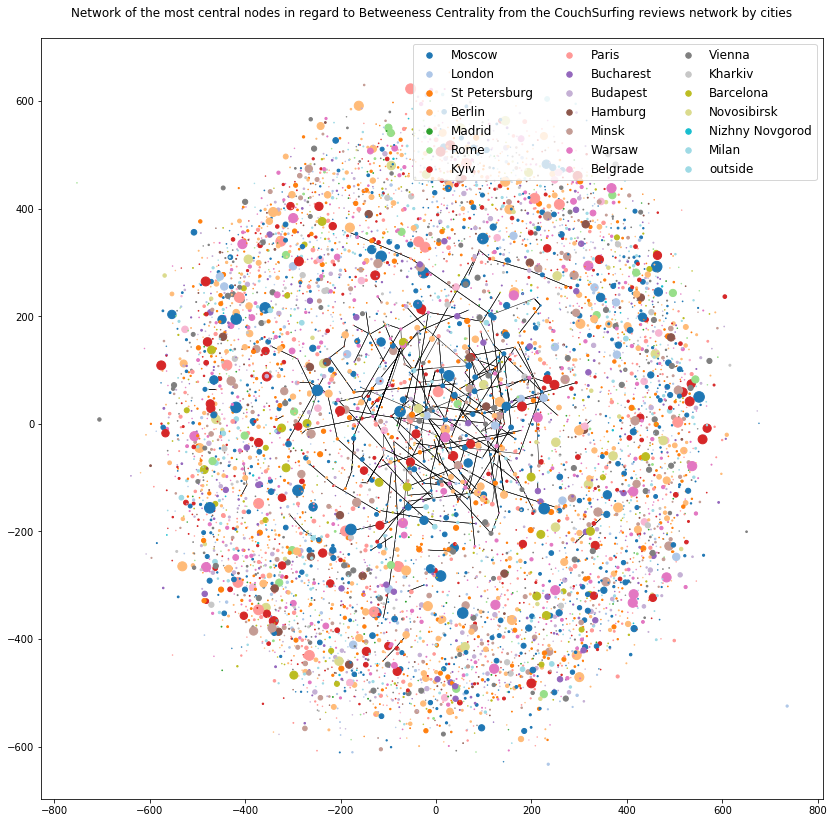

In [350]:
#create edges that connect relevant nodes concercing betweenness centrality

plt.figure(1,figsize=(14,14))

nx.draw_networkx_nodes(G_id, pos = positions_centrality,  node_color = color_map_nodes,node_size=[x[1]* 20000000 for x in relevant_nodes], with_labels=True)
nx.draw_networkx_edges(G_id,positions_centrality,edgelist = relevant_edges, edge_color='black', width = 0.5)

plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)

plt.title("Network of the most central nodes in regard to Betweeness Centrality from the CouchSurfing reviews network by cities\n")
plt.savefig('Network_of_the_most_central_nodes_in_regard_to_In_degree_centrlity.png', transparent = True, dpi = 500)
plt.show()

#### 4.3.3.2 Out-Degree Centrality

In [ ]:
out_degree_centrality = nx.out_degree_centrality(G_withSentValue)

no_odc_0 = list(out_degree_centrality.values()).count(0.0)
print("\n  Number of nodes with Eigenvector Centrality equal to 0: ",no_odc_0,"\n\n")
print("\n  Number of nodes with Eigenvector Centrality bigger than 0: ",len(list(out_degree_centrality.values()))-no_odc_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(out_degree_centrality.values()),'o') 
plt.title("Distribution of Out-Degree Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Out-Degree Centrality \n")
plt.show()

### 4.5. Modularity and Communities:

In [362]:
G_withSentValue_undirected = G_withSentValue.to_undirected()
partition = community.best_partition(G_withSentValue_undirected)
modularity = community.modularity(partition,G_withSentValue_undirected)
print(modularity)

0.14324786203123716


In [366]:
len(set(partition.values()))

2275

In [367]:
list_of_par_id = [v for k,v in partition.items() ]

In [374]:
list_of_par_id

[0,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 9,
 10,
 9,
 11,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 9,
 9,
 9,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 13,
 13,
 13,
 13,
 13,
 14,
 11,
 11,
 15,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 16,
 16,
 16,
 16,
 5,
 5,
 5,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 19,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 20,
 20,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 23,
 23,
 25,
 26,
 26,
 26,
 26,
 26,
 27,
 27,
 27,
 28,
 28,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 2,
 30,
 30,
 

In [377]:

print(max( [v for k,v in ggg.items() ]))

print(min( [v for k,v in ggg.items() ]))

1244
2


In [380]:
print( [k for k,v in ggg.items() if v == 1244 ])

[35]


In [381]:
ggg

Counter({0: 3,
         1: 426,
         2: 654,
         3: 395,
         4: 2,
         5: 482,
         6: 387,
         7: 518,
         8: 114,
         9: 451,
         10: 387,
         11: 328,
         12: 425,
         13: 280,
         14: 555,
         15: 448,
         16: 4,
         17: 382,
         18: 4,
         19: 234,
         20: 451,
         21: 371,
         22: 630,
         23: 406,
         24: 615,
         25: 609,
         26: 8,
         27: 3,
         28: 2,
         29: 2,
         30: 375,
         31: 400,
         32: 483,
         33: 197,
         34: 302,
         35: 1244,
         36: 476,
         37: 561,
         38: 2,
         39: 463,
         40: 344,
         41: 354,
         42: 455,
         43: 253,
         44: 256,
         45: 470,
         46: 210,
         47: 425,
         48: 375,
         49: 469,
         50: 487,
         51: 278,
         52: 222,
         53: 320,
         54: 327,
         55: 339,
         56: 526,
 

In [383]:
biggest_commnity =  [k for k,v in partition.items() if v == 35 ]

In [384]:
biggest_commnity

[2008055821,
 3573444,
 3387011,
 784084,
 357581,
 2000084520,
 980584,
 4842562,
 1754365,
 4673436,
 1562508,
 1001362,
 2002629882,
 2002750612,
 1000118798,
 2000532538,
 1006619088,
 2005924463,
 2005860532,
 920508,
 356538,
 1007262326,
 2003569099,
 1005048206,
 1005915315,
 1000777485,
 2002719216,
 2000152738,
 1000384879,
 2005588347,
 4864934,
 2004314466,
 2003647035,
 4816200,
 2000583128,
 2002710398,
 2003606730,
 1000748037,
 2000089831,
 1005109842,
 2000327767,
 2001667543,
 2008642208,
 2006977994,
 2784596,
 1005265069,
 2001074627,
 1003635296,
 2009253723,
 2005393107,
 5230119,
 2859881,
 1002820277,
 2007342200,
 1007317005,
 2008396271,
 2006465706,
 240929,
 2005546158,
 2005864552,
 2003668587,
 1155823,
 524254,
 1000958031,
 2000438959,
 736912,
 2002751146,
 2838217,
 1007520075,
 1007303199,
 2003820599,
 5490759,
 1003227327,
 1003221498,
 56116,
 530992,
 3025584,
 2009248579,
 2005549668,
 1006158328,
 2004495661,
 2007572843,
 4735771,
 1706628,
 50

In [372]:
max(list_of_par_id)


2274

In [388]:
cities_community = []

cities_community = [node_to_city_dict[k] for k in biggest_commnity]

In [389]:
cities_community

['outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'Barcelona',
 'outside',
 'Moscow',
 'outside',
 'outside',
 'outside',
 'Budapest',
 'Moscow',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'Warsaw',
 'outside',
 'outside',
 'London',
 'outside',
 'London',
 'Milan',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'outside',
 'London',
 'outside',
 'outside',
 'outside',
 'outside',
 'London',
 'outside',
 'outside',
 'outside',
 'Rome',
 'outside',
 'outside',
 'outside',
 

In [390]:
gggsd = collections.Counter(cities_community)
gggsd

Counter({'Barcelona': 5,
         'Berlin': 7,
         'Bucharest': 2,
         'Budapest': 4,
         'Hamburg': 2,
         'Kyiv': 3,
         'London': 5,
         'Madrid': 1,
         'Milan': 6,
         'Moscow': 2,
         'Paris': 15,
         'Rome': 1,
         'St Petersburg': 2,
         'Vienna': 4,
         'Warsaw': 2,
         'outside': 1183})

#### 5. Analysis of Review data